In [2]:
import gzip
from Bio import SeqIO
from Bio.Seq import Seq
from Bio import motifs
import numpy as np
import pandas as pd
import logomaker as lm
import matplotlib.pyplot as plt

In [3]:
annotationFile = "./ref/Homo_sapiens.GRCh38.112.chr.gtf.gz"
genomeFile = "./data/Homo_sapiens.GRCh38.dna_sm.primary_assembly.fa.gz"

In [4]:
# open the annotation data and get the exon coordinates
def getExonData(annotationFile):
    transcriptExons = {}
    with gzip.open(annotationFile, 'rt') as file: # "read text"
        for line in file:
            if line.startswith('#'):
                continue
            fields = line.strip().split('\t')
            if fields[2] == 'exon':
                chrom = fields[0]
                start = int(fields[3]) - 1 # fix indexing from 1-based to 0-based
                end = int(fields[4]) # end is inclusive in GTF so automatically adjusted
                strand = fields[6]
                attributes = fields[8] # get all the long semi-coloned information

                # some of the attributes have a section with something that looks like this: transcript_id "ENST00000424215";
                # so i need to check for "transcript_id" and then store the ENST000... ID thing in the transcriptID variable

                transcriptID = ""
                for attribute in attributes.split(';'):
                    if 'transcript_id' in attribute:
                        transcriptID = attribute.split('"')[1] # split the 'transcript_id "ENST000..."' and get the second element aka the transcript id
                        break

                if transcriptID not in transcriptExons:
                    transcriptExons[transcriptID] = [] # if its a new transcriptID initialize a list for exon coordinates under that transcript
        
                transcriptExons[transcriptID].append((chrom, start, end, strand))

    return transcriptExons

transcriptExons = getExonData(annotationFile)

for id, exons in list(transcriptExons.items())[:5]: #visualize the first 5 transcript id's and exon coordinates in the dictionary
    print(f"{id} : {exons}")

ENST00000424215 : [('1', 2581559, 2581650, '+'), ('1', 2583369, 2583495, '+'), ('1', 2584124, 2584533, '+')]
ENST00000511072 : [('1', 3069167, 3069296, '+'), ('1', 3186124, 3186474, '+'), ('1', 3244086, 3244137, '+'), ('1', 3385148, 3385286, '+'), ('1', 3396490, 3396593, '+'), ('1', 3402790, 3402998, '+'), ('1', 3404738, 3404886, '+'), ('1', 3405494, 3405648, '+'), ('1', 3411383, 3412800, '+'), ('1', 3414559, 3414647, '+'), ('1', 3417827, 3417997, '+'), ('1', 3418666, 3418744, '+'), ('1', 3425580, 3425750, '+'), ('1', 3426050, 3426225, '+'), ('1', 3430871, 3431108, '+'), ('1', 3433676, 3434342, '+')]
ENST00000607632 : [('1', 3069182, 3069296, '+'), ('1', 3186124, 3186591, '+')]
ENST00000378391 : [('1', 3069196, 3069296, '+'), ('1', 3186124, 3186474, '+'), ('1', 3244086, 3244137, '+'), ('1', 3385151, 3385286, '+'), ('1', 3396490, 3396593, '+'), ('1', 3402790, 3402998, '+'), ('1', 3404738, 3404886, '+'), ('1', 3405494, 3405648, '+'), ('1', 3411383, 3412800, '+'), ('1', 3414559, 3414647, 

In [13]:
def openGenomeFile(genomeFile): 
    genome = {}
    file = gzip.open(genomeFile, 'rt')
    for record in SeqIO.parse(file, "fasta"): # parse file and iterate through each record
        genome[record.id] = record.seq # store sequence in dictionary under its identifier
    return genome

genome = openGenomeFile(genomeFile)

for identifier, sequence in list(genome.items()): #visualize the first 5 id's and sequences in the dictionary
    print(f"{identifier} : {sequence[:30]}...")

1 : nnnnnnnnnnnnnnnnnnnnnnnnnnnnnn...
10 : nnnnnnnnnnnnnnnnnnnnnnnnnnnnnn...
11 : NNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...
12 : nnnnnnnnnnnnnnnnnnnnnnnnnnnnnn...
13 : NNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...
14 : NNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...
15 : NNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...
16 : nnnnnnnnnnnnnnnnnnnnnnnnnnnnnn...
17 : NNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...
18 : nnnnnnnnnnnnnnnnnnnnnnnnnnnnnn...
19 : NNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...
2 : nnnnnnnnnnnnnnnnnnnnnnnnnnnnnn...
20 : NNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...
21 : NNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...
22 : NNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...
3 : nnnnnnnnnnnnnnnnnnnnnnnnnnnnnn...
4 : nnnnnnnnnnnnnnnnnnnnnnnnnnnnnn...
5 : nnnnnnnnnnnnnnnnnnnnnnnnnnnnnn...
6 : NNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...
7 : nnnnnnnnnnnnnnnnnnnnnnnnnnnnnn...
8 : NNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...
9 : nnnnnnnnnnnnnnnnnnnnnnnnnnnnnn...
MT : GATCACAGGTCTATCACCCTATTAACCACT...
X : nnnnnnnnnnnnnnnnnnnnnnnnnnnnnn...
Y : nnnnnnnnnnnnnnnnnnnnnnnnnnnnnn...
KI270728.1 : GAATTCCCACACTGAGTAAAAAC

In [7]:
def getSpliceSites(transcriptExons, genome):
    fivePrimeSites = []
    threePrimeSites = []
    for id, exons in transcriptExons.items():
        for indx, exon in enumerate(exons):
            chrom, start, end, strand = exon[0], exon[1], exon[2], exon[3]
            
            # Exclude every first exons 3' site and every last exons 5' site
            if strand == '+':
                if start >= 20 and indx != 0:  # make sure its not the first exon of transcript and that there is enough upstream nucleotides
                    threePrimeSites.append((chrom, start - 20, start + 3, strand))
                    
                if end < len(genome[chrom]) - 6 and indx != len(exons) - 1: # make sure its not the last exon of transcript
                    fivePrimeSites.append((chrom, end - 3, end + 6, strand))

            elif strand == '-':
                if end < len(genome[chrom]) - 20 and indx != 0:  # make sure its not the first exon of transcript and that there is enough downstream nucleotides
                    threePrimeSites.append((chrom, end - 3, end + 20, strand))

                if indx != len(exons) - 1 and start >= 6: # make sure its not the last exon of transcript
                    fivePrimeSites.append((chrom, start - 6, start + 3, strand))

    return set(fivePrimeSites), set(threePrimeSites) # remove any duplicates

fivePrimeSites, threePrimeSites = getSpliceSites(transcriptExons, genome)

In [8]:
def extractSequences(spliceSites, genome):
    sequences = []
    for chrom, start, end, strand in spliceSites:
        seq = genome[chrom][start:end]
        if strand == '-':
            seq = str(seq.reverse_complement()) # reverse compliment so 3 and 5 prime are oriented correctly for compliment sequence
        else:
            seq = str(seq)
        sequences.append(seq)
    return sequences

fivePrimeSequences = extractSequences(fivePrimeSites, genome)
threePrimeSequences = extractSequences(threePrimeSites, genome)

In [9]:
# make position weight matrices
def makePWM(sequences):
    instances = []
    for seq in sequences:
        instances.append(Seq(seq)) # make everything into Seq objects for biopython motifs
    motif = motifs.create(instances)
    PWM = motif.counts.normalize() # change nucleotides into # of each and then into probabilities of each
    return PWM

fivePrimePWM = makePWM(fivePrimeSequences)
threePrimePWM = makePWM(threePrimeSequences)

print("Five Prime PWM:")
print(fivePrimePWM)

Five Prime PWM:
        0      1      2      3      4      5      6      7      8
A:   0.33   0.63   0.10   0.00   0.00   0.59   0.66   0.10   0.18
C:   0.35   0.11   0.03   0.00   0.02   0.04   0.08   0.07   0.15
G:   0.19   0.12   0.80   0.99   0.00   0.33   0.13   0.75   0.19
T:   0.13   0.14   0.07   0.00   0.98   0.04   0.12   0.09   0.47



In [10]:
# convert PWMs to DataFrames for Logomaker
def makeDataFrame(PWM):
    pwmList = []
    for base in "ACGT":
        pwmList.append(PWM[base]) # append row of probabilities for each base
    pwmArray = np.array(pwmList).T # make list into a np array and with probabilities for each base going in columns (transposed)
    dataFrame = pd.DataFrame(pwmArray, columns = list("ACGT")) # create a DataFrame from the np array with columns labeled A,C,G,T
    return dataFrame

fivePrimeDF = makeDataFrame(fivePrimePWM)
threePrimeDF = makeDataFrame(threePrimePWM)

print("Five Prime DataFrame:")
print(fivePrimeDF)

Five Prime DataFrame:
          A         C         G         T
0  0.331030  0.350229  0.189151  0.129590
1  0.630695  0.105185  0.122169  0.141952
2  0.101484  0.028320  0.795859  0.074338
3  0.004490  0.002009  0.990882  0.002618
4  0.003101  0.018639  0.003004  0.975257
5  0.586211  0.038208  0.334957  0.040625
6  0.663403  0.082669  0.132670  0.121258
7  0.096772  0.065258  0.751497  0.086472
8  0.181035  0.154330  0.192030  0.472605


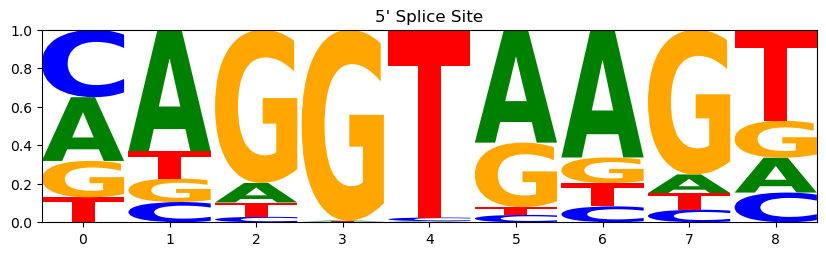

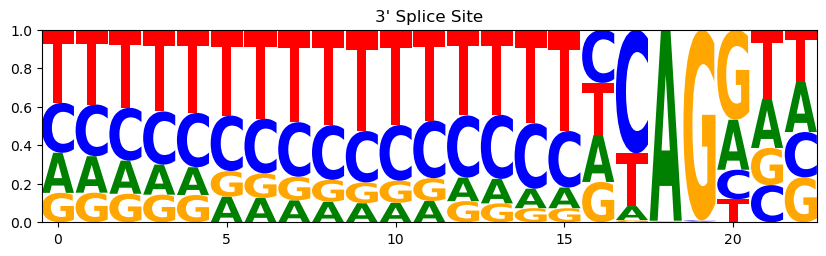

In [11]:
def plotLogo(dataFrame, title):
    logo = lm.Logo(dataFrame)
    logo.ax.set_title(title)
    plt.savefig(f"./plots/{title} logo") # save plots as images

plotLogo(fivePrimeDF, "5' Splice Site")
plotLogo(threePrimeDF, "3' Splice Site")